## <center style="color:blue;">**HamOrSpamAI**</center>

### <center>**Système Anti-Spam Intelligent**</center>

Ce projet vise à développer un système de classification automatique des emails pour identifier les messages spam et non-spam à l'aide de techniques de ml ou dl, avec un prétraitement des textes basé sur Nltk et TF-IDF.

<br>

### <span style="color:green;">**Chargement des Données :**</span>

#### <span style="color:orange;">**1. Décompresser le Dataset :**</span>

In [1]:
import rarfile as rf

ziped_file_path = "../data/ziped/emails.rar"
extracted_file_path = "../data/raw/"

with rf.RarFile(ziped_file_path) as archive:
    archive.extractall(extracted_file_path)

print("Extraction terminée avec succès.")

Extraction terminée avec succès.


#### <span style="color:orange;">**2. Renommer le Fichier de Dataset :**</span>

In [2]:
import os

file_name = os.listdir(extracted_file_path)[0]

os.rename(os.path.join(extracted_file_path, file_name), os.path.join(extracted_file_path, "data.csv"))

print("Renommage du fichier terminé avec succès.")

Renommage du fichier terminé avec succès.


#### <span style="color:orange;">**3. Créer la Session Spark :**</span>

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("HamOrSpamAI").getOrCreate()

print(f"- Version de Spark : {spark.version}")

- Version de Spark : 4.0.1


#### <span style="color:orange;">**4. Charger le Dataset :**</span>

In [4]:
df = spark.read.csv(
    os.path.join(extracted_file_path, "data.csv"), 
    header=True, 
    inferSchema=True, 
    encoding="ISO-8859-1",
    multiLine=True,
    escape='"'
)

df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- message_id: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- date: date (nullable = true)



In [5]:
df.show(5)

+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|_c0|message_id|                text|label|label_text|             subject|             message|      date|
+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
|  0|     33214|any software just...|    1|      spam|any software just...|understanding oem...|2005-06-18|
|  1|     11929|perspective on fe...|    0|       ham|perspective on fe...|19 th , 2 : 00 pm...|2001-06-19|
|  2|     19784|wanted to try ci ...|    1|      spam|wanted to try ci ...|viagra at $ 1 . 1...|2004-09-11|
|  3|      2209|enron / hpl actua...|    0|       ham|enron / hpl actua...|teco tap 30 . 000...|2000-12-12|
|  4|     15880|looking for cheap...|    1|      spam|looking for cheap...|water past also ,...|2005-02-13|
+---+----------+--------------------+-----+----------+--------------------+--------------------+----------+
only showing top 5 rows


In [6]:
df.count()

31716

In [7]:
df.describe().show()

+-------+-----------------+------------------+--------------------+------------------+----------+--------------------+--------------------+
|summary|              _c0|        message_id|                text|             label|label_text|             subject|             message|
+-------+-----------------+------------------+--------------------+------------------+----------+--------------------+--------------------+
|  count|            31716|             31716|               31665|             31716|     31716|               31442|               31371|
|   mean|          15857.5|16854.187539412284|                NULL|0.5096165973010468|      NULL|            386429.0|            71403.25|
| stddev|9155.764905238666| 9734.616391716854|                NULL|0.4999153936875302|      NULL|  481877.22667086066|   136659.2035841348|
|    min|                0|                 0| ( b  $ b ! zck...|                 0|       ham|                ( b| & who wants to ...|
|    max|           

In [8]:
df.summary().show()

+-------+-----------------+------------------+--------------------+------------------+----------+--------------------+--------------------+
|summary|              _c0|        message_id|                text|             label|label_text|             subject|             message|
+-------+-----------------+------------------+--------------------+------------------+----------+--------------------+--------------------+
|  count|            31716|             31716|               31665|             31716|     31716|               31442|               31371|
|   mean|          15857.5|16854.187539412284|                NULL|0.5096165973010468|      NULL|            386429.0|            71403.25|
| stddev|9155.764905238666| 9734.616391716854|                NULL|0.4999153936875302|      NULL|  481877.22667086066|   136659.2035841348|
|    min|                0|                 0| ( b  $ b ! zck...|                 0|       ham|                ( b| & who wants to ...|
|    25%|           

#### <span style="color:orange;">**5. Expliquer Chaque Colonne du Dataset :**</span>

| **Colonne**    | **Type** | **Description**                                                                           |
| -------------- | -------- | ----------------------------------------------------------------------------------------------------------------------- |
| **_c0**        | string   | Colonne générée automatiquement (index, numéro de ligne ou colonne vide). Pas utile pour l’analyse ou le modèle. Peut être supprimée.                         |
| **message_id** | string   | Identifiant unique de l’email. Utile pour le suivi et l’unicité des emails, mais pas utilisé pour le modèle.                       |
| **text**       | string   | Texte brut complet de l’email. Peut contenir le contenu complet avant nettoyage. Utilisable pour le NLP mais souvent bruité. |
| **label**      | string   | Label binaire de classification : "0" = ham (non-spam), "1" = spam. C’est la variable cible du modèle.                                                    |
| **label_text** | string   | Version textuelle du label (ex : "spam", "ham"). Redondant avec `label`, utile pour la lecture humaine mais pas nécessaire pour le modèle.                    |
| **subject**    | string   | Objet de l’email. Très utile pour détecter les spams. Une feature importante en NLP.      |
| **message**    | string   | Corps principal de l’email. Champ le plus propre et le plus utile pour entraîner le modèle de détection spam.                              |
| **date**       | string   | Date d’envoi de l’email. Utile pour l'analyse temporelle, mais rarement pour la prédiction.                        |


<br>

### <span style="color:green;">**Détection et Gestion des Valeurs Manquantes et des Doublons :**</span>

#### <span style="color:orange;">**1. Diviser les Colonnes selon le Type :**</span>

In [9]:
numerics = [c for c, t in df.dtypes if t == 'int']
strings = [c for c, t in df.dtypes if t == 'string']

print(f"- Colonnes numériques : {numerics}")
print(f"- Colonnes chaînes de caractères : {strings}")

- Colonnes numériques : ['_c0', 'message_id', 'label']
- Colonnes chaînes de caractères : ['text', 'label_text', 'subject', 'message']


#### <span style="color:orange;">**2. Détecter les Valeurs Manquantes dans les Colonnes Numériques :**</span>

In [10]:
from pyspark.sql.functions import *

missing_numeric = df.select([
    sum(
        ((col(c).isNull()) | (isnan(col(c)))).cast("int")
    ).alias(c)
    for c in numerics
])

missing_numeric.show()

+---+----------+-----+
|_c0|message_id|label|
+---+----------+-----+
|  0|         0|    0|
+---+----------+-----+



#### <span style="color:orange;">**3. Détecter les Valeurs Manquantes dans les Colonnes Texte :**</span>

##### **3.1. Détecter le Nombre des Valeurs Manquantes dans Chaque Colonne :**

In [11]:
missing_string = df.select([
    sum(
        (col(c).isNull() | (col(c) == "")).cast("int")
    ).alias(c)
    for c in strings
])

missing_string.show()

+----+----------+-------+-------+
|text|label_text|subject|message|
+----+----------+-------+-------+
|  51|         0|    274|    345|
+----+----------+-------+-------+



##### **3.2. Sélectionner les Colonnes contenant des Valeurs Manquantes :**

In [12]:
stmt_missing_cols = missing_string.select([
    (col(c) > 0).alias(c) 
    for c in strings
])

cols = stmt_missing_cols.collect()

cols = cols[0].asDict()

missing_cols = [c for c, v in cols.items() if v]

missing_cols

['text', 'subject', 'message']

#### <span style="color:orange;">**4. Supprimer les Valeurs Manquantes :**</span>

In [13]:
print(df.count())

df = df.dropna(subset=missing_cols)

print(df.count())

31716
31148


#### <span style="color:orange;">**5. Calculer le Nombre des Doublons :**</span>

In [14]:
total_rows = df.count()
distinct_rows = df.distinct().count()
duplicates = total_rows - distinct_rows

print(f"Nombre de doublons : {duplicates}")

Nombre de doublons : 0


<br>

### <span style="color:green;">**Analyse de la Distribution de la Variable Cible :**</span>

#### <span style="color:orange;">**1. Définir la Variable Cible :**</span>

In [15]:
target = "label"

#### <span style="color:orange;">**2. Analyser la Distribution :**</span>

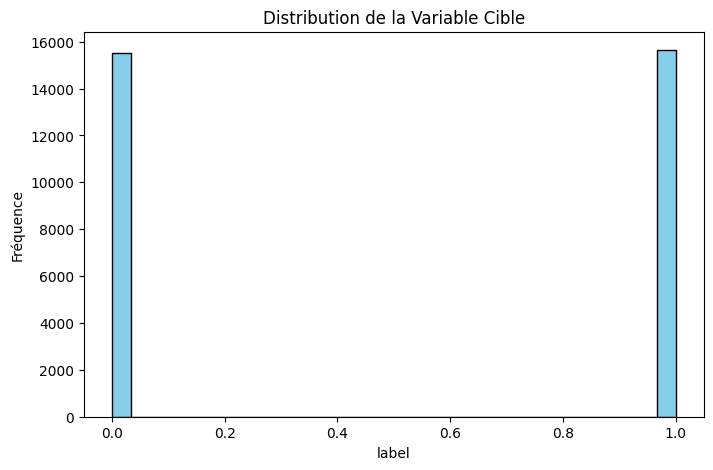

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

pdf = df.toPandas()

plt.figure(figsize=(8, 5))
plt.hist(pdf[target], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution de la Variable Cible")
plt.xlabel("label")
plt.ylabel("Fréquence")
plt.show()

- **Nature de la Variable :** La variable cible est binaire (catégorielle à deux classes), car seules les valeurs 0 et 1 sont présentes.

- **Fréquences :** Les deux barres, correspondant aux labels 0 et 1, atteignent approximativement la même hauteur, autour de 15 800 (ou une valeur très proche).

- **Équilibre des Classes :** Les deux classes ont un nombre d'échantillons presque identique.

<br>

**Conclusion :**

Il n'y a pas de problème de déséquilibre de classe majeur, ce qui simplifie l'évaluation des performances.

<br>

### <span style="color:green;">**Génération des WordClouds :**</span>

#### <span style="color:orange;">**1. WordCloud :**</span>

##### **1.1. Définition :**

Un WordCloud (nuage de mots) est une visualisation graphique d’un texte où la taille d’un mot dépend de sa fréquence dans le texte. C'est à dire plus un mot apparaît souvent, plus il est affiché en grand.

##### **1.2. À quoi ça sert ?**

- Comprendre rapidement les mots dominants dans un corpus.

- Avoir une vue d’ensemble des thèmes principaux.

- Détecter les mots parasites ou trop fréquents.

- Vérifier si le prétraitement NLP a bien fonctionné.

- Illustrer des rapports et analyses.

##### **1.3. Quel est le rôle d’un WordCloud dans un pipeline NLP ?**

Dans un projet NLP, le WordCloud n’est pas utilisé pour entraîner un modèle. Son rôle est surtout dans la partie exploratoire (EDA), c’est-à-dire analyser et comprendre les données.

Il intervient généralement après :

- Nettoyage du texte

- Tokenisation

- Suppression des stopwords

- Lemmatisation

À ce moment-là, on génère un WordCloud pour observer les mots les plus importants et vérifier que le nettoyage est correct.

##### **1.4. C’est quoi les Stopwords ?**

Les stopwords sont des mots très fréquents dans une langue mais qui n’apportent pas de valeur sémantique réelle dans l’analyse.

- Exemples en français : `le`, `la`, `les`, `un`, `une`, `de`, `à`, `dans`, `et`, `pour` ...

- Exemples en anglais : `the`, `a`, `an`, `to`, `in`, `on`, `is`, `are` ...

Comme ces mots n’aident pas à comprendre le sens du texte, on les supprime pour réduire le bruit et améliorer les modèles NLP.

#### <span style="color:orange;">**2. Générer un WordCloud pour les Messages Spam :**</span>

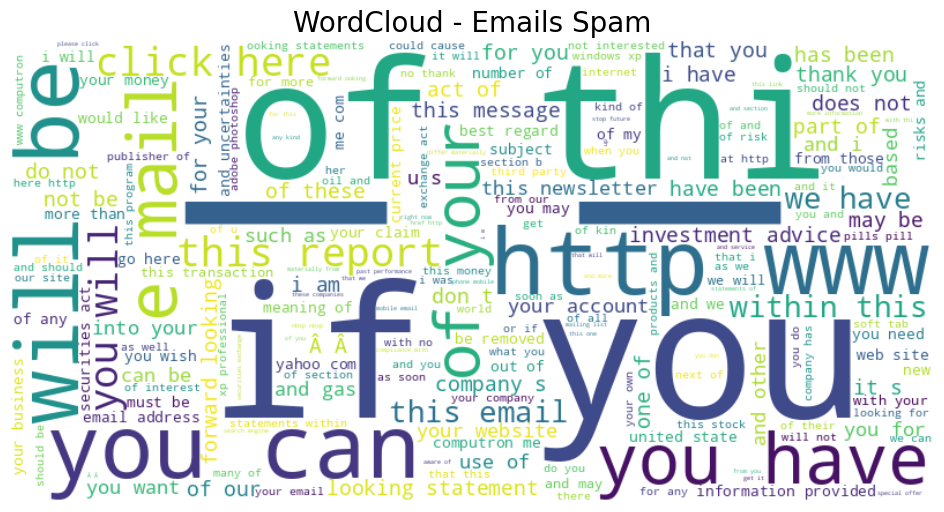

In [20]:
from wordcloud import WordCloud

spam_text = " ".join(
    row["text"] for row in df.filter(df.label == 1).select("text").collect()
)

spam_wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=set(['the', 'a', 'an', 'to', 'in', 'on', 'is', 'are'])
).generate(spam_text)

plt.figure(figsize=(12, 6))
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Emails Spam", fontsize=20)
plt.show()

#### <span style="color:orange;">**3. Générer un WordCloud pour les Messages Ham (Non Spam) :**</span>

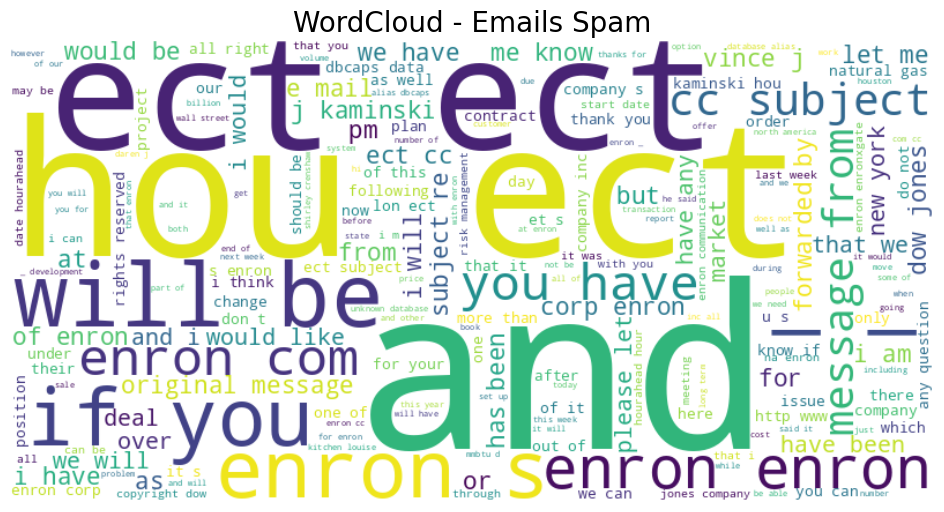

In [21]:
spam_text = " ".join(
    row["text"] for row in df.filter(df.label == 0).select("text").collect()
)

spam_wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=set(['the', 'a', 'an', 'to', 'in', 'on', 'is', 'are'])
).generate(spam_text)

plt.figure(figsize=(12, 6))
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Emails Spam", fontsize=20)
plt.show()

<br>

### <span style="color:green;">**Enregistrement du Dataset :**</span>

In [19]:
pdf.to_csv("../data/clean/data.csv", index=False)

print("Fichier Sauvegardé avec Succès !")

Fichier Sauvegardé avec Succès !
